Skewness: 1.31
Kurtosis: 1.11


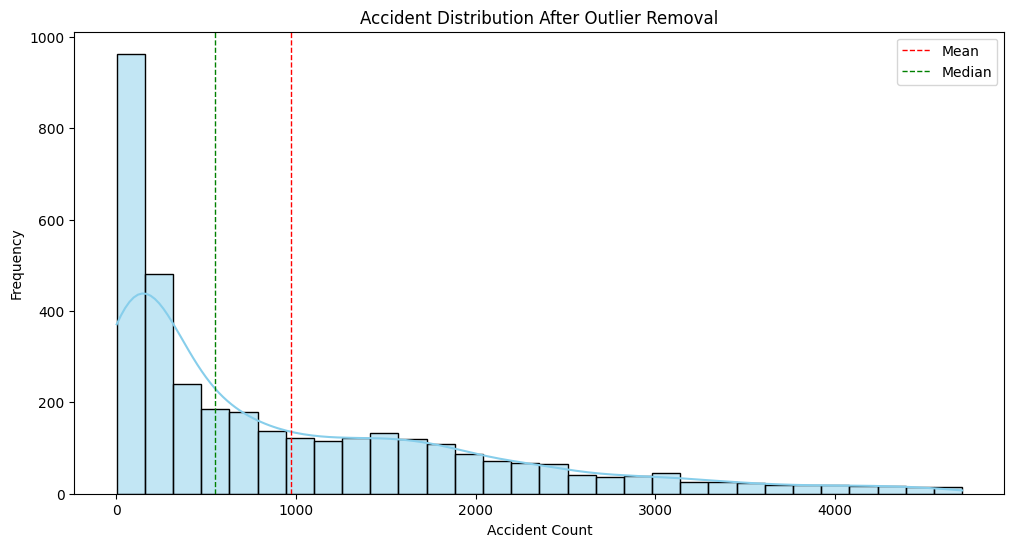

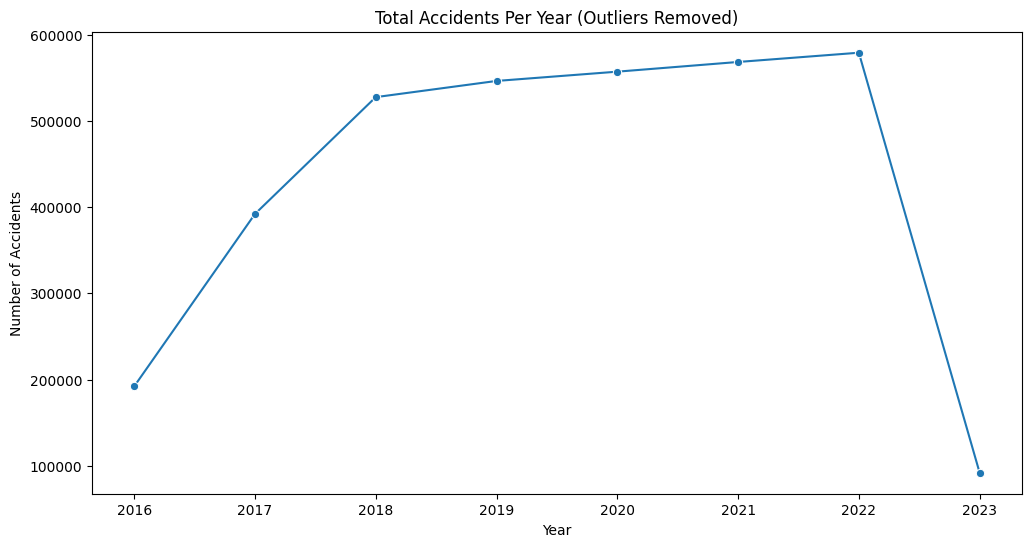

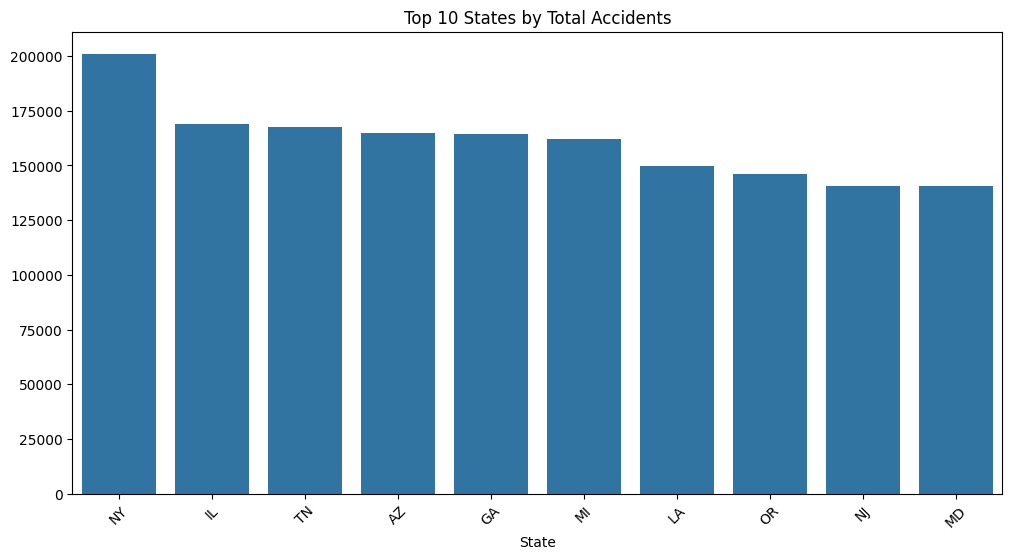

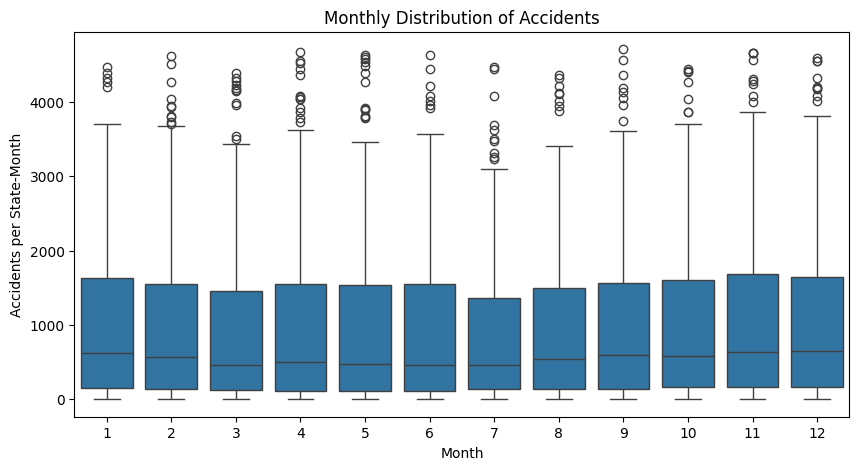


Linear Regression Evaluation:
MAE: 708.80
R² Score: 0.43
RMSE: 866.21

Random Forest Evaluation:
MAE: 534.78
R² Score: 0.48
RMSE: 828.76


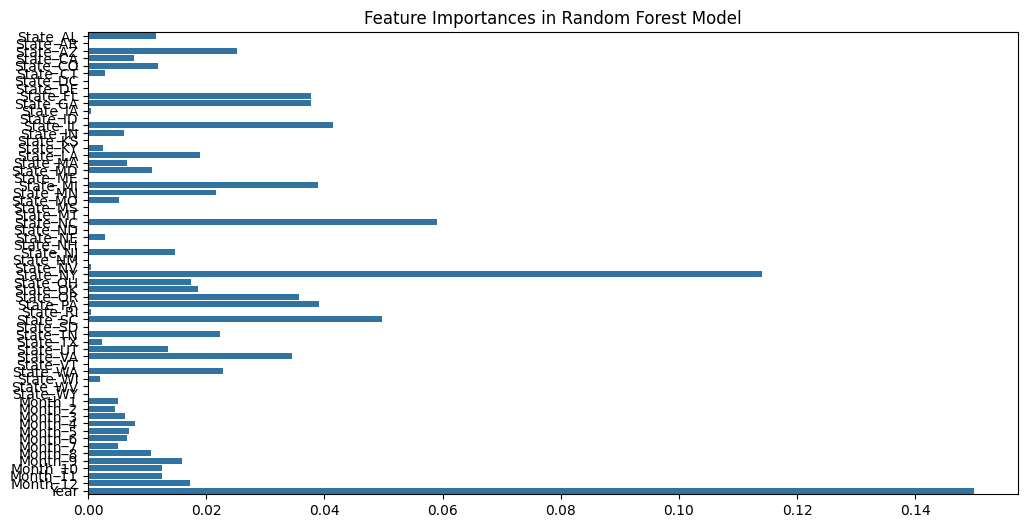

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import skew, kurtosis

# Load the dataset
df = pd.read_csv('/content/USA_ACCIDENTS.csv', encoding='latin-1')

# Convert to datetime and extract temporal features
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed', errors='coerce')
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek  # Monday=0, Sunday=6

# Aggregate accidents by state and month-year
accident_counts = df.groupby(['State', 'Year', 'Month']).size().reset_index(name='Accident_Count')

# --- 🛠️ Outlier Removal using IQR ---
Q1 = accident_counts['Accident_Count'].quantile(0.25)
Q3 = accident_counts['Accident_Count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
accident_counts = accident_counts[(accident_counts['Accident_Count'] >= lower_bound) &
                                  (accident_counts['Accident_Count'] <= upper_bound)]

# --- 📊 Skewness and Kurtosis ---
skewness = accident_counts['Accident_Count'].skew()
kurt = accident_counts['Accident_Count'].kurtosis()

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")

# --- 📈 Visualization: Distribution After Outlier Removal ---
plt.figure(figsize=(12, 6))
sns.histplot(accident_counts['Accident_Count'], bins=30, kde=True, color='skyblue')
plt.title('Accident Distribution After Outlier Removal')
plt.xlabel('Accident Count')
plt.ylabel('Frequency')
plt.axvline(accident_counts['Accident_Count'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(accident_counts['Accident_Count'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

# --- 📅 Global Trend of Accidents Over Time ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=accident_counts.groupby('Year')['Accident_Count'].sum().reset_index(),
             x='Year', y='Accident_Count', marker='o')
plt.title("Total Accidents Per Year (Outliers Removed)")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.show()

# --- 🗺️ Top 10 States with Highest Accidents ---
top_states = accident_counts.groupby('State')['Accident_Count'].sum().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.barplot(x=top_states, y=accident_counts.groupby('State')['Accident_Count'].sum().nlargest(10).values)
plt.title("Top 10 States by Total Accidents")
plt.xticks(rotation=45)
plt.show()

# --- 📊 Monthly Distribution of Accidents ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=accident_counts, x='Month', y='Accident_Count')
plt.title("Monthly Distribution of Accidents")
plt.xlabel("Month")
plt.ylabel("Accidents per State-Month")
plt.show()

# --- 🚦 Prepare Data for Modeling ---
X = accident_counts[['State', 'Year', 'Month']]
y = accident_counts['Accident_Count']

# Time-based split: Train on earlier years, test on later years
train = accident_counts[accident_counts['Year'] < 2020]
test = accident_counts[accident_counts['Year'] >= 2020]

X_train, y_train = train[['State', 'Year', 'Month']], train['Accident_Count']
X_test, y_test = test[['State', 'Year', 'Month']], test['Accident_Count']

# --- 🔧 Preprocessing: One-hot encode categorical variables ---
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['State', 'Month'])],
    remainder='passthrough'
)

# --- 🔥 Linear Regression Pipeline ---
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# --- 🌲 Random Forest Pipeline ---
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# --- ✅ Model Evaluation Function ---
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")

# Evaluate both models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)

# --- 🌟 Feature Importance for Random Forest ---
encoder = preprocessor.named_transformers_['cat']
feature_names = encoder.get_feature_names_out(['State', 'Month'])
feature_names = np.concatenate([feature_names, ['Year']])

importances = rf_pipeline.named_steps['regressor'].feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances in Random Forest Model")
plt.show()


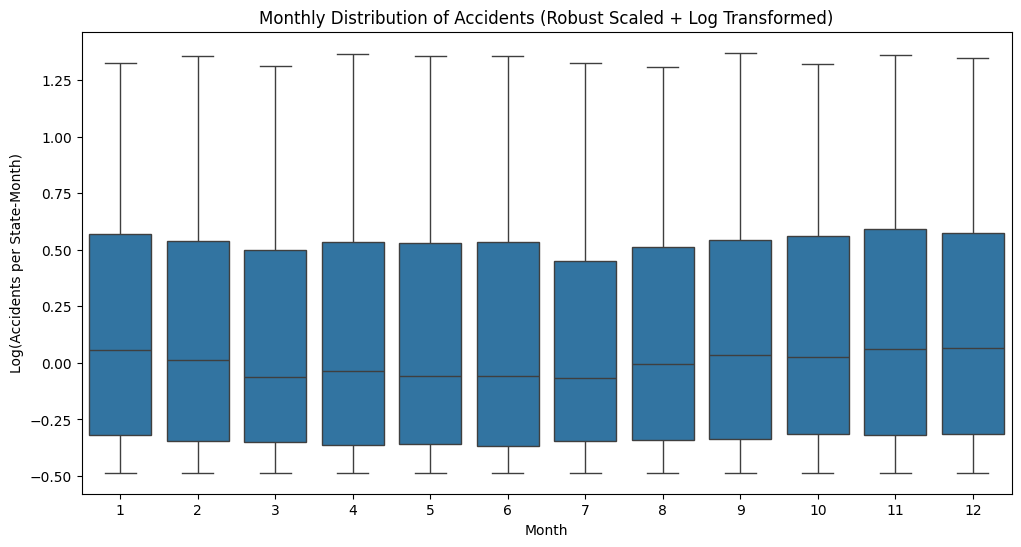

In [13]:
from sklearn.preprocessing import RobustScaler

# Apply Robust Scaling
scaler = RobustScaler()
accident_counts['Accident_Count_Scaled'] = scaler.fit_transform(accident_counts[['Accident_Count']])

# Apply Log Transformation
accident_counts['Accident_Count_Log_Scaled'] = np.log1p(accident_counts['Accident_Count_Scaled'])

# Plot the results
plt.figure(figsize=(12, 6))
sns.boxplot(data=accident_counts, x='Month', y='Accident_Count_Log_Scaled')
plt.title("Monthly Distribution of Accidents (Robust Scaled + Log Transformed)")
plt.xlabel("Month")
plt.ylabel("Log(Accidents per State-Month)")
plt.show()

